In [297]:
import pandas as pd
import numpy as np
import random
import math
import gc
from collections import defaultdict
import matplotlib.pylab as plt
import networkx as nx
from copy import deepcopy

In [298]:
random.seed(1)
num_vertices = 35
num_ants = 20
edges = []
vertices = list(range(num_vertices))
# Initialize adjacency matrix
def init_adjacency_matrix(nodes, edges):
    adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)
    edge_probability = .0085 if nodes > 100 else 0.09
    edges_cnt = 0
    for i in range(nodes):
        for j in range(i):
            prob = random.random()
            if prob < edge_probability:
                adjacency_matrix[i,j] = 1
                edges.append((i,j))
                edges_cnt += 1
    ant_adjacency_matrix = {ant:deepcopy(adjacency_matrix) for ant in range(num_ants)}
    return ant_adjacency_matrix, edges
ant_adjacency_matrix, edges = init_adjacency_matrix(num_vertices, edges)

In [299]:
G=nx.Graph()
G.add_nodes_from(list(range(num_vertices)))
G.add_edges_from(edges)

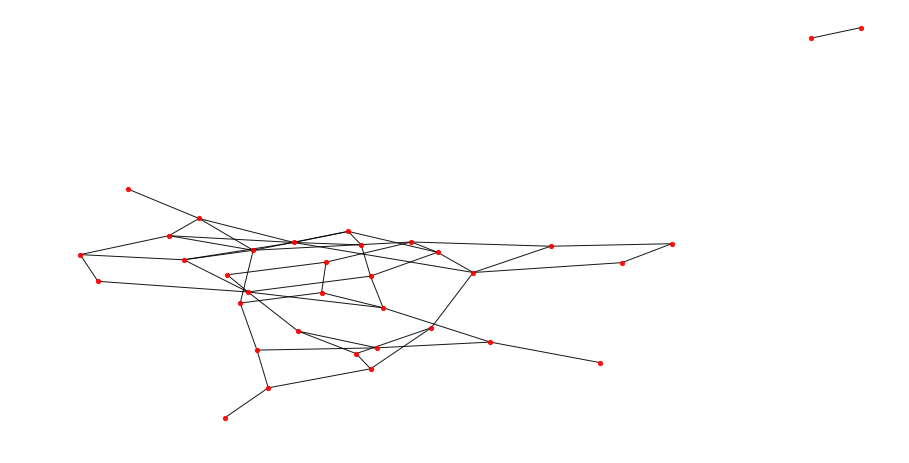

In [300]:
plt.figure(figsize=(12,6))
nx.draw(G, node_color='r',node_size=18, alpha=0.9)
plt.show() # display

In [301]:
# Initialize variables and constants
ant_dict = {ant: [random.choice(range(num_vertices)), 0] for ant in range(num_ants)} # ant: (curr_vertex, num_of_vertices_visited)
vertex_weights = {node:1 for node in range(num_vertices)}
tau_o = random.random() 
ant_solutions = {ant: [] for ant in range(num_ants)}
ant_finisher = None
q_o = 0.7
alpha = 0.5
psi = 0.3

In [302]:
#Vertex Cover Greedy Algorithm
visited = np.zeros(num_vertices)
greedy_vertex_dict = {}
greedy_edges = deepcopy(edges)

for vertex in range(num_vertices):
    greedy_vertex_dict[vertex] = sum(ant_adjacency_matrix[0][vertex])/vertex_weights[vertex]

greedy_vertex_dict_ordered = dict(sorted(greedy_vertex_dict.items(), key=lambda item: item[1], reverse=True))

greedy_count = 0
vcount = 0
for vertex in greedy_vertex_dict_ordered:
    to_remove = set()
    for edge in greedy_edges:
        if vertex in edge:
            to_remove.add(edge)
    for edge in to_remove:
        greedy_edges.remove(edge)
    greedy_count +=vertex_weights[vertex]
    vcount += 1
    if len(greedy_edges) == 0: 
        break

In [303]:
vcount, greedy_count

(28, 28)

In [304]:
# Helpers
def get_available_vertices(ant, ant_adjacency_matrix):
    vertices = []
    for ind,row in enumerate(ant_adjacency_matrix[ant]):
        if sum(row) > 0:
            vertices.append(ind)
    return list(set(vertices) - set(ant_solutions[ant]))

def get_arg_max_phermone():
    arg_max = []
    max_val = -1
    for vertex, value in vertex_values.items():
        # print(value, max_val)
        if value > max_val:
            max_val = value
            arg_max = [vertex]
            
        elif value == max_val:
            arg_max.append(vertex)
            
    return arg_max
def get_psi_k(ant, ant_adjacency_matrix, vertex_i, vertex_j):
    return ant_adjacency_matrix[ant][vertex_i][vertex_j]

# Eta function
def get_eta_k(ant, ant_adj_matrix, vertex):
    total_edges = sum([get_psi_k(ant, ant_adj_matrix, vertex_i,vertex_j) for vertex_i in range(num_vertices) for vertex_j in range(num_vertices)])
    weight_vertex = vertex_weights[vertex]
    return total_edges/weight_vertex

In [305]:
vertex_phermones = {node:tau_o for node in range(num_vertices)}
vertex_values = {node: vertex_phermones[node]*get_eta_k(0,ant_adjacency_matrix, node)**alpha for node in range(num_vertices)}
print(ant_dict)

{0: [16, 0], 1: [21, 0], 2: [14, 0], 3: [16, 0], 4: [15, 0], 5: [1, 0], 6: [25, 0], 7: [20, 0], 8: [27, 0], 9: [15, 0], 10: [17, 0], 11: [12, 0], 12: [4, 0], 13: [10, 0], 14: [28, 0], 15: [9, 0], 16: [16, 0], 17: [29, 0], 18: [33, 0], 19: [10, 0]}


In [306]:
# Probability
def get_transition_probabilty(ant,vertex_j,vertex_i=None, q_o=q_o, available_vertices = None, ant_adjacency_matrix=ant_adjacency_matrix):
    # vertex_j is current vertex and vertex_i is adjacent vertex
    q = random.random()
    if q <=q_o or not vertex_i:
        tau_j = vertex_phermones[vertex_j]
        eta_j_k = (get_eta_k(ant, ant_adjacency_matrix, vertex_j))**alpha
        if not available_vertices:
            available_vertices = get_available_vertices(ant, ant_adjacency_matrix)
        denominator = sum([tau_j*get_eta_k(ant, ant_adjacency_matrix, vert) for vert in available_vertices])
        return tau_j*eta_j_k / denominator
    
    arg_max = get_arg_max_phermone()
    if vertex_i in arg_max:
        return 1
    return 0
        

# Local update rule
def get_local_tau_j(vertex_j):
    return (1-psi)*vertex_phermones[vertex_j] + psi*tau_o
    
# Global update rule 
def get_delta_tau_j(ant):
    total_weights = sum([vertex_weights[vertex_j] for vertex_j in ant_solutions[ant]])
    return 1/(total_weights) if total_weights > 0 else 0
    
def get_tau(ant, vertex_i, local_phermone):
    delta_tau = get_delta_tau_j(ant)
    tau = (1-get_transition_probabilty(ant, vertex_i))*(local_phermone+vertex_phermones[vertex_i]) + delta_tau # We update based on local and current global phermones
    return tau

def update_eta_k(ant, vertex, available_vertices = None, ant_adjacency_matrix=ant_adjacency_matrix):
    if not available_vertices:
        available_vertices = get_available_vertices(ant, ant_adjacency_matrix)
    # print("fnerfrewfw",sum([vertex_phermones[node]*get_eta_k(node)**alpha for node in available_vertices]))
    vertex_values[vertex] = sum([vertex_phermones[node]*get_eta_k(ant, ant_adjacency_matrix, node)**alpha for node in available_vertices])
    return 
        

def an_ant_finished(ant_adjacency_matrix):
    global ant_finisher
    ants_count = 0
    for ant in range(num_ants):
        if ants_finished(ant, ant_adjacency_matrix):
            ant_finisher = ant
            return True
    return False

# Change this function
def ants_finished(ant, ant_adjacency_matrix):
    ants_finished = True
    for row in ant_adjacency_matrix[ant]:
        if sum(row) != 0: 
            ants_finished = False
            break
    if ants_finished:
        print(f"{ant} finished")
    return ants_finished

def visit_vertex_steps(adj_vertex, num_vertices_visited, ant):
    ant_solutions[ant].append(adj_vertex)
    ant_dict[ant] = [adj_vertex, num_vertices_visited+1]
    
    # Update adjacency matrix
    ant_adjacency_matrix[ant][adj_vertex] = [0]*num_vertices
    for row in range(num_vertices):
        ant_adjacency_matrix[ant][row][adj_vertex] = 0
    return 

In [307]:
def start_ACO(ant_adjacency_matrix):
    local_phermone_dict = defaultdict(int)
    i = 0
    for ant, (curr_vertex, num_vertices_visited) in ant_dict.items():
        visit_vertex_steps(curr_vertex, num_vertices_visited, ant)
        
    break_now = False
    global ant_solutions
    
    while not (an_ant_finished(ant_adjacency_matrix)):
        print(i)
        i+=1
        local_phermone_dict = defaultdict(int) # vertex: phermone used to sotre local phermone status
        for ant, (curr_vertex, num_vertices_visited) in ant_dict.items():
            if num_vertices_visited == num_vertices:
                print("{ant} done")
                continue# Ant has not visited all vertices; ant is not finished
            random_prob =  random.random()
            available_vertices = get_available_vertices(ant, ant_adjacency_matrix)
            if not available_vertices:
                print(f"{ant} is DONE!")
                ant_finisher = ant
            random.shuffle(available_vertices)
            
            for adj_vertex in available_vertices:
                if adj_vertex in ant_solutions[ant]:
                    continue
                prob = get_transition_probabilty(ant,curr_vertex, adj_vertex, available_vertices=available_vertices)
                random_prob =  random.random()
                if random_prob <= prob:
                    visit_vertex_steps(adj_vertex, num_vertices_visited, ant)
                        
                    # Update local phermone
                    local_phermone_val = get_local_tau_j(adj_vertex)
                    local_phermone_dict[adj_vertex] += local_phermone_val
                    
                    # Update eta 
                    update_eta_k(ant, adj_vertex) 
                    break
        
        for ant in range(num_ants):
        
            for vertex, local_phermone in local_phermone_dict.items():
                # Not sure if this should be local or global
                vertex_phermones[vertex] =  get_tau(ant, vertex, local_phermone) # This function uses local and global phermones for update
    return ant_solutions    

In [308]:
solutions_found = start_ACO(ant_adjacency_matrix)
solutions = solutions_found[ant_finisher]
print("Ant finisher is", ant_finisher)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


C:\Users\shriv\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


7 finished
Ant finisher is 7


In [311]:
print(solutions_found)
solutions = solutions_found[ant_finisher]
print(solutions)

{0: [16, 32, 8, 30, 15, 6, 12, 26, 7, 11, 27, 4, 33, 21, 25, 29, 20], 1: [21, 8, 30, 15, 25, 32, 11, 7, 28, 5, 12], 2: [14, 29, 18, 32, 28, 17, 4, 20, 7, 16, 19, 6, 24], 3: [16, 32, 29, 18, 15, 11, 6, 5, 33, 24, 17, 4, 21, 34, 19, 25], 4: [15, 21, 8, 30, 11, 14, 32, 17, 28, 7, 5, 16, 6, 27, 25], 5: [1, 15, 32, 19, 24, 20, 7, 33, 4, 6, 5, 29], 6: [25, 32, 30, 15, 5, 24, 31, 11, 21, 28, 34, 6, 26, 20], 7: [20, 6, 18, 21, 25, 17, 32, 31, 24, 26, 34, 28, 4, 12, 33, 5, 22, 16, 11, 30, 14, 15, 23, 8, 19], 8: [27, 30, 18, 24, 17, 21, 33, 11, 8, 7, 34, 29], 9: [15, 19, 11, 8, 33, 24, 7, 34, 21, 4, 6, 30, 29, 25, 12], 10: [17, 18, 5, 25, 32, 11, 34, 24, 14, 30, 19, 26, 20, 21, 33, 4, 15, 16, 29, 28, 12, 27], 11: [12, 15, 30, 6, 29, 17, 8, 31, 7, 16, 28, 21, 11, 32], 12: [4, 32, 21, 18, 5, 25, 27, 31, 24, 28, 22, 16, 33, 8, 30, 34, 14, 20, 12], 13: [10, 30, 6, 29, 24, 11, 18, 5, 17, 4, 14, 26, 28, 27, 16, 32, 23], 14: [28, 18, 5, 11, 27, 33, 30, 20, 12, 21, 19, 6, 25, 24], 15: [9, 30, 34, 18, 15

C:\Users\shriv\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


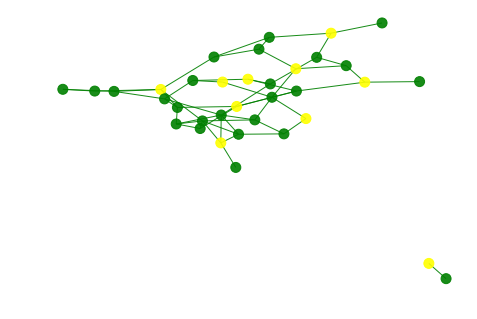

1.0
ACO: 25, Greedy Algorithm: 28


In [312]:
color_map = []

for node in G:
    if node in solutions:
        color_map.append('green')
    else: 
        color_map.append('yellow')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
nx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=100, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
ant_cost = 0
for vertex in solutions:
    ant_cost += vertex_weights[vertex]
print(f"ACO: {ant_cost}, Greedy Algorithm: {greedy_count}")